In [260]:
import requests as req
import pandas as pd
import re
import pprint
import gzip
import json

In [727]:
from sklearn import preprocessing

In [822]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier

In [799]:
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# regex pattern to get the protein \[protein=([\w\s]*)\]
# regex pattern to get the cds segment \]\\n([ATGC\\n]+)>?
# regex pattern to get all the segment \\n([\\nATCG]+)

In [ ]:
# GC-content https://en.wikipedia.org/wiki/GC-content
# CDS https://en.wikipedia.org/wiki/Coding_region

In [905]:
# euk  = pd.read_csv("C:/Users/Myself/Desktop/Unimib/2Introduzione all'intelligenza artificiale/Progetto/eukaryotes/eukaryotes.csv")
# prok  = pd.read_csv("C:/Users/Myself/Desktop/Unimib/2Introduzione all'intelligenza artificiale/Progetto/prokaryotes/prokaryotes.csv")
viruses  = pd.read_csv("C:/Users/Myself/Desktop/Unimib/2Introduzione all'intelligenza artificiale/Progetto/viruses/viruses.csv")

In [906]:
# Drop unused columns
viruses.drop(labels=["Replicons.1", "RefSeq FTP", "BioSample", "BioProject", "Assembly", "Release Date", "Neighbors", "Level"], axis=1, inplace=True)

# Replace missing values
viruses.loc[[4297],["Replicons"]] = "729029461"

# Easier to work with integers
viruses["Size"] = (viruses["Size(Mb)"]*1000000).astype(int)

In [907]:
viruses.head()

,#Organism Name,Organism Groups,Size(Mb),GC%,Replicons,Host,CDS,GenBank FTP,Size
0,Hamiltonella virus APSE1,"Viruses;dsDNA viruses, no RNA stage;Podoviridae",0.036524,43.900,Unknown:NC_000935.1/AF157835.1,bacteria,54,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,36524
1,Chalara elegans RNA Virus 1,Viruses;dsRNA viruses;Totiviridae,0.005310,52.600,Unknown:NC_005883.1/AY561500.1,fungi,2,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,5310
2,Vibrio phage martha 12B12,"Viruses;dsDNA viruses, no RNA stage;Myoviridae",0.033277,45.800,Unknown:NC_021070.1/HQ316581.1,bacteria,51,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,33277
3,Sclerotinia sclerotiorum partitivirus S,Viruses;dsRNA viruses;Partitiviridae,0.003726,44.145,RNA 1:NC_013014.1/GQ280377.1; RNA 2:NC_01301...,plants,2,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,3726
4,Human papillomavirus 116,"Viruses;dsDNA viruses, no RNA stage;Papillomav...",0.007184,38.500,Unknown:NC_013035.1/FJ804072.1,vertebrates,7,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,7184


In [811]:
viruses.describe(include="object")

,#Organism Name,Organism Groups,BioProject,Assembly,Replicons,Host,GenBank FTP
count,7362,7362,2978,7362,7362,7354,7362
unique,4893,17,2937,7362,7362,13,7362
top,Rotavirus A,Viruses;dsRNA viruses;Reoviridae,PRJNA222858,GCA_000837745.1,Unknown:NC_000935.1/AF157835.1,bacteria,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...
freq,1314,2463,37,1,1,3787,1


In [922]:
host_dict = {}
for host_name in viruses["Host"]:
    if(host_name in host_dict):
        host_dict[host_name] += 1
    else:
        host_dict[host_name] = 1

In [923]:
host_dict

{'bacteria': 3787,
 'fungi': 55,
 'plants': 306,
 'vertebrates': 550,
 'invertebrates': 107,
 'protozoa': 34,
 'vertebrates, invertebrates, human': 8,
 'invertebrates, plants': 11,
 'algae': 34,
 'vertebrates, invertebrates': 17,
 'vertebrates, human': 2440,
 'archaea': 4,
 'human': 1,
 nan: 8}

In [930]:
arr = []
for i in host_dict.keys():
    arr.append(i)

In [933]:
print(arr[:-1])

['bacteria', 'fungi', 'plants', 'vertebrates', 'invertebrates', 'protozoa', 'vertebrates, invertebrates, human', 'invertebrates, plants', 'algae', 'vertebrates, invertebrates', 'vertebrates, human', 'archaea', 'human']


In [ ]:
[3787, 55, 306, 550, 107, 34, 8, 11, 34, 17, 2440, 4, 1], x=['bact', 'fungi', 'plants', 'vert', 'invert', 'prot', 'v/i/h', 'i/p', 'algae', 'v/i', 'v/u', 'archaea', 'h']

In [943]:
df_normal_a = pd.DataFrame(data = [3787, 55, 306, 550, 107, 34, 8, 11, 34, 17, 2440, 4, 1], columns=['frequency'])
df_normal_b = pd.DataFrame(data = ['bact', 'fungi', 'plants', 'vert', 'invert', 'prot', 'v/i/h', 'i/p', 'algae', 'v/i', 'v/u', 'archaea', 'h'], columns=['host'])

score_data = pd.concat([df_normal_a, df_normal_b], axis = 1)

In [944]:
score_data

,frequency,host
0,3787,bact
1,55,fungi
2,306,plants
3,550,vert
4,107,invert
5,34,prot
6,8,v/i/h
7,11,i/p
8,34,algae
9,17,v/i


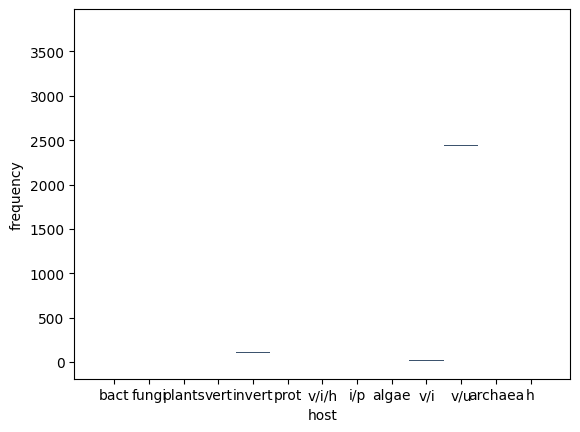

In [958]:
sn.histplot(score_data, x="host", y="frequency", discrete=True)
plt.show()

In [916]:
viruses["Host"].unique()

array(['bacteria', 'fungi', 'plants', 'vertebrates', 'invertebrates',
       'protozoa', 'vertebrates, invertebrates, human',
       'invertebrates, plants', 'algae', 'vertebrates, invertebrates',
       'vertebrates, human', 'archaea', 'human', nan], dtype=object)

In [365]:
# Building the url to retrive the genome from the server
GenBank = []
for i in viruses["GenBank FTP"]:
    link = "https" + i[3:] + "/" + i[55:]
    GenBank.append(link)
    if(i[55:58] != "GCA" or i[0:3] != "ftp"):
        print(i)

In [497]:
protein_array = []
genome_size_array = []
mismatch_array = []
error_array = []

In [498]:
# The following code make requests to a server, it is time consuming and may not be appriciated
# run only if necessary
for index in range(0, len(GenBank)):
    try:
        req_protein = req.get(GenBank[index] + "_cds_from_genomic.fna.gz")
        req_size = req.get(GenBank[index] +"_genomic.fna.gz")
        req_protein = gzip.decompress(req_protein._content).decode()
        req_size = gzip.decompress(req_size._content).decode()
        for rep in ["B", "D", "E", "F", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "U", "V", "Z"]:
            req_size = req_size.replace(rep, "")
        protein_list = re.findall("\[protein=([\w\s]*)\]", req_protein)
        protein_list_unique = []
        for protein in protein_list:
            if protein not in protein_list_unique:
                protein_list_unique.append(protein)
        protein_array.append(protein_list_unique)
        genome = ""
        for segment in re.findall("\\n([\\nATCG]+)", req_size):
            genome += segment
        genome_size = len(genome.replace("\n", ""))
        genome_size_array.append(genome_size)
        if(genome_size != viruses["Size"][index]):
            print(index, genome_size, viruses["Size"][index])
            mismatch_array.append([index, genome_size, viruses["Size"][index]])
    except Exception as e:
        print(index, e)
        error_array.append([index, e])

32 176675 176677
38 11560 11563
54 171796 171797
70 18499 18500
80 179979 179980
90 167692 167716
100 184368 184409
111 8126 8125
126 44054 44055
141 235226 235229
143 127063 127065
178 168900 168903
187 131993 131995
210 Not a gzipped file (b'<?')
216 Not a gzipped file (b'<?')
240 Not a gzipped file (b'<?')
241 Not a gzipped file (b'<?')
256 43039 43198
260 44969 44970
270 50912 50913
272 41830 41831
290 39892 39898
294 138390 137821
308 63882 63881
319 Not a gzipped file (b'<?')
320 Not a gzipped file (b'<?')
330 7857 7856
332 161612 161773
347 Not a gzipped file (b'<?')
396 Not a gzipped file (b'<?')
402 131486 131522
420 8178 8177
422 195858 195859
425 79225 81755
433 15401 148687
437 41489 41491
448 Not a gzipped file (b'<?')
463 28697 28699
472 4578 4674
473 5115 5133
477 7356 7448
493 4748 4844
507 131153 131160
517 37962 37966
520 Not a gzipped file (b'<?')
524 21128 21129
525 7876 7875
530 130706 130705
537 5128 5129
538 4488 4553
555 7402 7434
559 13741 13883
563 8027 8026
5

5218 16829 18020
5221 17130 18155
5223 17904 17968
5226 17937 17958
5232 17979 17980
5234 17612 18177
5235 16236 18139
5236 17316 17838
5271 18484 18485
5273 17239 17407
5281 17407 17411
5372 18048 18061
5383 17342 17345
5384 17338 17339
5386 17308 17310
5387 17296 17297
5396 17378 17379
5397 17388 17391
5401 17304 17349
5405 17376 17397
5411 17357 17358
5415 17374 17379
5416 17309 17342
5420 17366 17373
5421 17305 17358
5423 17384 17385
5427 17354 17355
5430 17298 17355
5432 17341 17355
5433 17270 17331
5434 17275 17355
5435 17394 17397
5436 17336 17397
5437 17310 17358
5441 17363 17364
5446 18606 18607
5447 17846 17847
5448 18606 18607
5449 18606 18607
5450 18606 18607
5495 18418 18419
5506 18488 18489
5517 18016 18091
5603 18498 18513
5617 18562 18602
5626 18042 18043
5628 18024 18045
5637 17932 17933
5641 17963 17964
5642 18024 18050
5644 18028 18088
5648 18096 18098
5650 18593 18613
5651 17450 17451
5653 18058 18060
5716 8841 8843
5749 17864 18027
5782 8906 8907
5803 18457 18530
5

In [ ]:
mismatch_array_int = mismatch_array
for num_int in mismatch_array_int:
    num_int[2] = int(num_int[2])

In [ ]:
error_array_serializable = []
for error_instance in error_array:
    if type(error_instance[1]) == gzip.BadGzipFile:
        error_array_serializable.append([error_instance[0], 0])
    else:
        error_array_serializable.append([error_instance[0], 1])

In [ ]:
with open('protein_array.txt', 'w') as filehandle:
    json.dump(protein_array, filehandle)
    
with open('genome_size_array.txt', 'w') as filehandle:
    json.dump(genome_size_array, filehandle)
    
with open('mismatch_array.txt', 'w') as filehandle:
    json.dump(mismatch_array_int, filehandle)
    
with open('error_array.txt', 'w') as filehandle:
    json.dump(error_array_serializable, filehandle)

In [563]:
protein_frequency = {}
for proteins in protein_array:
    for protein in protein:
        if(protein in protein_frequency):
            protein_frequency[protein] += 1
        else:
            protein_frequency[protein] = 1

In [609]:
seri_protein = pd.Series(dtype=str)
seri_frequency = pd.Series(dtype=int)
for protein in protein_frequency.keys():
    seri_protein = pd.concat([seri_protein, pd.Series(protein)])
    seri_frequency = pd.concat([seri_frequency, pd.Series(protein_frequency[protein])])

C:\Users\Myself\AppData\Local\Temp\ipykernel_25252\3156206590.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  seri_protein = pd.Series()
C:\Users\Myself\AppData\Local\Temp\ipykernel_25252\3156206590.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  seri_frequency = pd.Series()


In [612]:
# Instantiate protein dataframe
frame = { 'protein': seri_protein, 'frequency': seri_frequency }
df_prot = pd.DataFrame(frame)

# Sort protein dataframe by protein frequency
df_prot.sort_values(by=['frequency'], inplace=True, ascending=False)

# Add indexing to the dataframe
df_prot['index'] = range(0, len(df_prot))
df_prot.set_index("index", inplace=True)

In [821]:
# Display the 400 most commons proteins founded in the viruses dataset
for index in range (0, 400):
    print('{:55s} {:4d}'.format(df_prot["protein"][index], df_prot["frequency"][index]))

hypothetical protein                                    3633
portal protein                                          1716
major capsid protein                                    1639
terminase large subunit                                 1465
tape measure protein                                    1242
holin                                                   1153
minor tail protein                                      1143
HNH endonuclease                                        1115
major tail protein                                      1102
inner capsid protein VP6                                1002
DNA polymerase                                           983
tail assembly chaperone                                  971
VP1                                                      881
VP3                                                      874
VP2                                                      867
VP4                                                      857
terminase small subunit 

In [845]:
type(df_prot["protein"])

pandas.core.series.Series

In [659]:
# Remove faulty data from the viruses dataset, mainly gzip file and connection errors
error_index = []
for error_element in error_array:
    error_index.append(error_element[0])
    
viruses_dropped = viruses.drop(error_index)

In [669]:
# Recalibrate dataframe index
viruses_dropped['index'] = range(0, len(viruses_dropped))
viruses_dropped.set_index("index", inplace=True)

In [684]:
# Make sure the virus dataframe has the same length as the protein array
assert(len(viruses_dropped) == len(protein_array))

In [700]:
# Create a list populated by pandas series
# the value in each slot is 0 if the virus doesn't produce
# the protein, and 1 if it does
protein_series_list = []
for j in range(0, 400):
    protein = []
    for i in range(0, len(viruses_dropped)):
        if (df_prot["protein"][j] in protein_array[i]):
            protein.append(1)
        else:
            protein.append(0)
    protein_series_list.append(pd.Series(protein, dtype=int))

In [722]:
new_viral_df = viruses_dropped.copy()
new_viral_df.drop(labels=['#Organism Name', 'Organism Groups', 'BioProject', 'Assembly',
       'Size(Mb)', 'Replicons', 'Neighbors',
       'GenBank FTP'], axis=1, inplace=True)
new_viral_df.columns

Index(['GC%', 'Host', 'CDS', 'Size'], dtype='object')

In [725]:
targets_host = new_viral_df.pop('Host')

In [903]:
x = new_viral_df.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

unclean_viral_df = pd.DataFrame(x_scaled)

unclean_viral_df.insert(0, 'Host', targets_host)



In [904]:
# Concatenate GC% and size with the 400 categorical protein variables
unclean_viral_df = pd.concat([unclean_viral_df, *protein_series_list], axis=1)
unclean_viral_df.columns = ["Host", "GC", "CDS", "Size", *df_prot["protein"][0:400].tolist()]
unclean_viral_df

,Host,GC,CDS,Size,hypothetical protein,portal protein,major capsid protein,terminase large subunit,tape measure protein,holin,...,100K,putative head protein,gp24,gp1,putative receptor binding protein,putative dihydrofolate reductase,large terminase subunit,gp49,gp4,gp48
0,bacteria,0.571615,0.059887,0.073089,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fungi,0.684896,0.001130,0.010327,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,bacteria,0.596354,0.056497,0.066560,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,plants,0.574805,0.001130,0.007142,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,vertebrates,0.501302,0.006780,0.014095,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,"vertebrates, human",0.413264,0.012429,0.035921,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7287,"vertebrates, human",0.436421,0.011299,0.037079,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7288,"vertebrates, human",0.429182,0.011299,0.037079,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7289,"vertebrates, human",0.415827,0.011299,0.035921,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [917]:
print(unclean_viral_df["Host"].isna().sum())

# remove the NaN values!
new_df_clean = unclean_viral_df.dropna()

2


In [918]:
y = new_df_clean['Host']
X = new_df_clean.drop(['Host'], axis=1)
y.columns = ['Host']

In [919]:
X

,GC,CDS,Size,hypothetical protein,portal protein,major capsid protein,terminase large subunit,tape measure protein,holin,minor tail protein,...,100K,putative head protein,gp24,gp1,putative receptor binding protein,putative dihydrofolate reductase,large terminase subunit,gp49,gp4,gp48
0,0.571615,0.059887,0.073089,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.684896,0.001130,0.010327,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.596354,0.056497,0.066560,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.574805,0.001130,0.007142,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.501302,0.006780,0.014095,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,0.413264,0.012429,0.035921,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7287,0.436421,0.011299,0.037079,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7288,0.429182,0.011299,0.037079,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7289,0.415827,0.011299,0.035921,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [962]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
                                            
linear_pred = linear.predict(X_test)

# retrieve accuracy
accuracy_lin = linear.score(X_test, y_test)

print("acc linear kernel: ", accuracy_lin)

cm_lin = confusion_matrix(y_test, linear_pred)

acc linear kernel:  0.9272976680384087


<AxesSubplot:>

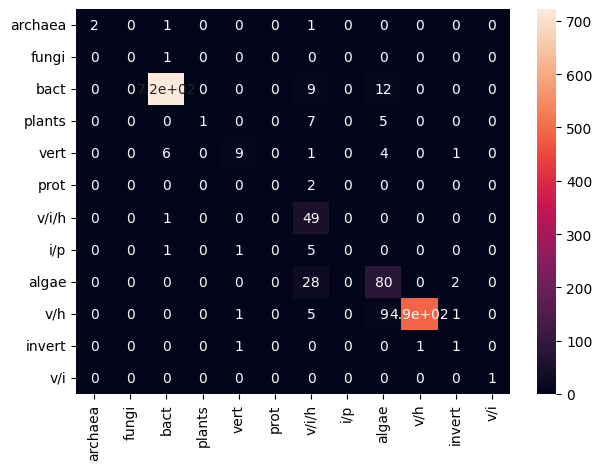

In [964]:
df_cm = pd.DataFrame(cm_lin, index = [i for i in ['archaea', 'fungi', 'bact', 'plants', 'vert', 'prot', 'v/i/h', 'i/p', 'algae', 'v/h', 'invert', 'v/i']],
                  columns = ['archaea', 'fungi', 'bact', 'plants', 'vert', 'prot', 'v/i/h', 'i/p', 'algae', 'v/h', 'invert', 'v/i'])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True)

In [972]:
# Testing a random forest classifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
clf_prediction = clf.predict(X_test)

# retrieve accuracy
accuracy_clf = clf.score(X_test, y_test)

print("acc random forest: ", accuracy_clf)

cm_lin = confusion_matrix(y_test, clf_prediction)

acc random forest:  0.8463648834019204


<AxesSubplot:>

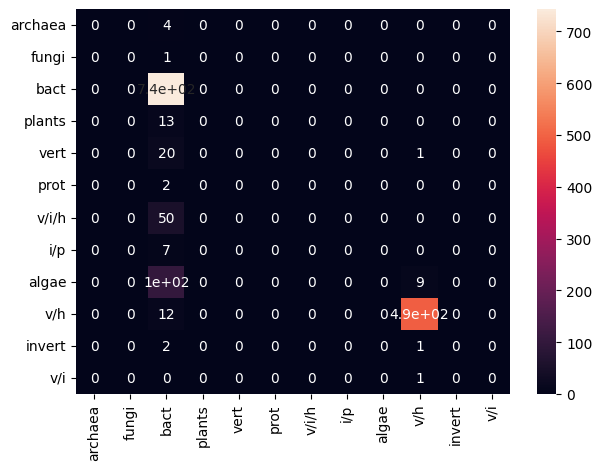

In [973]:
df_cm = pd.DataFrame(cm_lin, index = [i for i in ['archaea', 'fungi', 'bact', 'plants', 'vert', 'prot', 'v/i/h', 'i/p', 'algae', 'v/h', 'invert', 'v/i']],
                  columns = [i for i in ['archaea', 'fungi', 'bact', 'plants', 'vert', 'prot', 'v/i/h', 'i/p', 'algae', 'v/h', 'invert', 'v/i']])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True)